# CS4701 Project: Personal Color Analysis

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import transformers
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import os
import torch

import random
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

random.seed(0)
torch.manual_seed(0)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(F"Device set to {device}")

Device set to cpu


# Step 1: Create Dataset

### Define ColorSeasonDataset class

In [9]:
class ColorSeasonDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, indices=None):
        """
        Args:
            root_dir (string): Root directory containing the RGB-M folder
            split (string): 'train' or 'test'
            transform (callable, optional): Transform to apply to images
            indices (list, optional): If provided, only use these indices
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # Define season and subtype mapping
        self.seasons = ['spring', 'summer', 'autumn', 'winter']
        self.subtypes = {
            'spring': ['warm', 'light', 'bright'],
            'summer': ['cool', 'light', 'soft'],
            'autumn': ['warm', 'deep', 'soft'],
            'winter': ['cool', 'deep', 'bright']
        }
        
        # Collect all image paths and corresponding labels
        self.image_paths = []
        self.labels = []
        
        base_path = os.path.join(root_dir, 'RGB-M', split)
        
        for season_idx, season in enumerate(self.seasons):
            season_path = os.path.join(base_path, season)
            if not os.path.isdir(season_path):
                continue
                
            for subtype_idx, subtype in enumerate(self.subtypes[season]):
                subtype_path = os.path.join(season_path, subtype)
                if not os.path.isdir(subtype_path):
                    continue
                    
                for img_file in os.listdir(subtype_path):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(season_path, subtype, img_file))
                        
                        # Calculate combined label (0-11 for 4 seasons × 3 subtypes)
                        combined_label = season_idx * 3 + subtype_idx
                        self.labels.append(combined_label)
        
        # If indices are provided, use only those
        if indices is not None:
            self.image_paths = [self.image_paths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

### Define transforms to data and create train/test datasets

**Note here**: 
- The authors split the data into 4000 images for training and 900 images for testing (80-20 split)
- It's good practice to have validation set but I'm skipping it for now because I'll use stratified k-fold cross validation later
- This is because the dataset is small so I don't want to lose more data by splitting test set it into validation set

In [ ]:
# Define the path to the data
PATH_TO_DATA = 'TODO: path to data'

In [10]:
# Define random transforms for training time
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     # transforms.RandAugment(2, 7), # not sure about this because I don't want colors changing for color classification
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Less aggressive crop
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Small rotation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Occasional perspective
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Small hue adjustment
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.5)),  # Occasional blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define fixed transforms for test time
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 2: Train Model

In [ ]:
#import the joint loss model classifier
%load_ext autoreload
%aimport joint_model_loss
%autoreload 1
from models.joint_loss_model import ColorSeasonClassifier, kfold_crossval
from loss_functions import joint_loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_dataset = ColorSeasonDataset(
    root_dir=PATH_TO_DATA,
    split='train',
    transform=train_transform
)

test_dataset = ColorSeasonDataset(
    root_dir=PATH_TO_DATA,
    split='test',
    transform=test_transform
)

model_class = ColorSeasonClassifier()
criterion = joint_loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Define a few parameter configurations to try
param_configs = [
    # {
    #     'name': 'Default Config',
    #     'learning_rate': 1e-4,
    #     'weight_decay': 1e-4,
    #     'alpha': 0.4,
    #     'beta': 0.4,
    #     'gamma': 0.2,
    #     'num_epochs': 10,
    #     'batch_size': 32
    # },
    {
        'name': 'I wanna try giving more weight to the season classification',
        'learning_rate': 2e-5,
        'weight_decay': 0.01,
        'alpha': 0.6,
        'beta': 0.3,
        'gamma': 0.1,
        'num_epochs': 30,
        'batch_size': 64,
        'dropout_rate': 0.5,
        'patience': 5,
        'warmup_steps': 25 # set to 50 if batchsize 32
    },
    # {
    #     'name': 'Higher LR Config',
    #     'learning_rate': 3e-4,
    #     'weight_decay': 1e-4,
    #     'alpha': 0.4,
    #     'beta': 0.4,
    #     'gamma': 0.2,
    #     'num_epochs': 10,
    #     'batch_size': 32
    # },
    # {
    #     'name': 'Season Focus Config',
    #     'learning_rate': 1e-4,
    #     'weight_decay': 1e-4,
    #     'alpha': 0.6,  # More weight on season
    #     'beta': 0.2,
    #     'gamma': 0.2,
    #     'num_epochs': 10,
    #     'batch_size': 32
    # }
]

In [ ]:
import time

# Evaluate each configuration using k-fold CV
results = []
for config in param_configs:
    start_time = time.time()
    
    result = kfold_crossval(
        params=config,
        train_dataset=train_dataset,
        val_dataset=train_dataset,
        model_class=model_class,
        criterion=criterion,
        test_transform=test_transform,
        device=device,
        n_splits=5
    )
    
    elapsed_time = time.time() - start_time
    print(f"Evaluation took {elapsed_time:.1f} seconds")
    
    results.append(result)

# Find the best configuration
best_result = max(results, key=lambda x: x['avg_best_val_acc'])
best_config = best_result['params']

print(f"\nBest configuration: {best_config['name']}")
print(f"Average validation accuracy: {best_result['avg_best_val_acc']:.4f}")

# Method 2: Comparing ViT with EfficientNet

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import transformers
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm # For progress bar during training
from PIL import Image
import os
import torch
import sys
import random
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

random.seed(0)
torch.manual_seed(0)

In [ ]:
#Mount your Google Drive; this allows the runtime environment to access your drive.
drive.mount('/content/gdrive')

# NOTE: Make sure your path does NOT include a '/' at the end!
base_dir = "/content/gdrive/path-to-base-directory"
sys.path.append(base_dir)

In [ ]:
#Create your path to your train and validation datasets. It should be setup such 
#that your /train and /validation folder contains the datasets for each of the 4 seasons.
train_dir = '/content/gdrive/MyDrive/path-to-train-directory'
val_dir = '/content/gdrive/MyDrive/path-to-val-directory'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(F"Device set to {device}")

In [ ]:
# Define random transforms for training time
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.RandAugment(2, 7), # not sure about this because I don't want colors changing for color classification
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#batch sizing for 32, 64, and 128 should yield similar results.
batch_size = 128

train_dataset = datasets.ImageFolder(train_dir, transform = train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform = train_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
model = EfficientNet.from_pretrained('efficientnet-b7')

# Modify the final layer for 4 classes (for your classification task)
model._fc = nn.Linear(model._fc.in_features, 4)
model.to(device)

# Freeze the layers except the final classification layer
for param in model.parameters():
  param.requires_grad = False

# Unfreeze the last fully connected layer (final classification head)
for param in model._fc.parameters():
    param.requires_grad = True

#loss function and optimizer is cross entropy and Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model._fc.parameters(), lr=0.0001)

In [ ]:
#Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_preds = 0
  total_preds = 0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)

    total_preds += labels.size(0)

    correct_preds += (predicted == labels).sum().item()

  avg_train_loss = running_loss / len(train_loader)
  train_losses.append(avg_train_loss)
  train_accuracy = correct_preds / total_preds
  train_accuracies.append(train_accuracy)
  print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")


  #Validation phase
  model.eval()
  val_running_loss = 0.0
  val_correct_preds = 0
  val_total_preds = 0
  with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, labels)
      val_running_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      val_total_preds += labels.size(0)
      val_correct_preds += (predicted == labels).sum().item()

  avg_val_loss = val_running_loss / len(val_loader)
  val_losses.append(avg_val_loss)
  val_accuracy = val_correct_preds / val_total_preds
  val_accuracies.append(val_accuracy)

  print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
# After training, you can evaluate the final accuracy on the validation set
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
#Plot the training and validation accuracies over the epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Method 3: ResNet50

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import transformers
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
from tqdm import tqdm # For progress bar during training
from PIL import Image
import os
import torch
import sys
import random
import os
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

#from google.colab import drive

random.seed(0)
torch.manual_seed(0)

In [2]:
modelresnet50 = models.resnet50(pretrained=True)
model = models.resnet50(weights='DEFAULT')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Define random transforms for training time
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.RandAugment(2, 7), # not sure about this because I don't want colors changing for color classification
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
base_dir = '/Users/carlaflores/cs4701/RGB'
train_dir = '/Users/carlaflores/cs4701/RGB/train'
val_dir = '/Users/carlaflores/cs4701/RGB/train'
#Update to match your path

In [ ]:
batch_size = 32
train_dataset = datasets.ImageFolder(train_dir, transform = train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform = train_transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)


model_class = ColorSeasonClassifier()
criterion = joint_loss


model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(2048, 4),
                             nn.ReLU(),
                             nn.Linear(4, 4))
model.to(device)

#loss function and optimizer is cross entropy and Adam for now
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/carlaflores/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:09<00:00, 38.0MB/s] 


126


In [17]:
#Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_preds = 0
  total_preds = 0
  for inputs, labels in tqdm(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)

    total_preds += labels.size(0)

    correct_preds += (predicted == labels).sum().item()

  avg_train_loss = running_loss / len(train_loader)
  train_losses.append(avg_train_loss)
  train_accuracy = correct_preds / total_preds
  train_accuracies.append(train_accuracy)
  print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")


  #Validation phase
  model.eval()
  val_running_loss = 0.0
  val_correct_preds = 0
  val_total_preds = 0
  with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, labels)
      val_running_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      val_total_preds += labels.size(0)
      val_correct_preds += (predicted == labels).sum().item()

  avg_val_loss = val_running_loss / len(val_loader)
  val_losses.append(avg_val_loss)
  val_accuracy = val_correct_preds / val_total_preds
  val_accuracies.append(val_accuracy)

  print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")
# After training, you can evaluate the final accuracy on the validation set
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

100%|██████████| 126/126 [15:17<00:00,  7.28s/it]


Train Loss: 1.3969 | Train Accuracy: 0.3466


100%|██████████| 126/126 [10:05<00:00,  4.81s/it]


Val Loss: 1.4200 | Val Accuracy: 0.2443


100%|██████████| 126/126 [52:30<00:00, 25.00s/it]  


Train Loss: 1.4209 | Train Accuracy: 0.2438


100%|██████████| 126/126 [16:14<00:00,  7.73s/it] 


Val Loss: 1.4195 | Val Accuracy: 0.2440


100%|██████████| 126/126 [24:35<00:00, 11.71s/it]


Train Loss: 1.4204 | Train Accuracy: 0.2438


100%|██████████| 126/126 [15:22<00:00,  7.32s/it]


Val Loss: 1.4191 | Val Accuracy: 0.2440


100%|██████████| 126/126 [28:00<00:00, 13.34s/it]


Train Loss: 1.4200 | Train Accuracy: 0.2443


100%|██████████| 126/126 [14:55<00:00,  7.11s/it]


Val Loss: 1.4186 | Val Accuracy: 0.2438


100%|██████████| 126/126 [24:55<00:00, 11.87s/it]


Train Loss: 1.4195 | Train Accuracy: 0.2440


100%|██████████| 126/126 [15:33<00:00,  7.41s/it]


Val Loss: 1.4181 | Val Accuracy: 0.2433


100%|██████████| 126/126 [24:52<00:00, 11.85s/it]


Train Loss: 1.4191 | Train Accuracy: 0.2438


100%|██████████| 126/126 [15:14<00:00,  7.26s/it]


Val Loss: 1.4177 | Val Accuracy: 0.2445


100%|██████████| 126/126 [1:09:33<00:00, 33.12s/it] 


Train Loss: 1.4186 | Train Accuracy: 0.2443


100%|██████████| 126/126 [10:56<00:00,  5.21s/it]


Val Loss: 1.4172 | Val Accuracy: 0.2445


100%|██████████| 126/126 [20:10<00:00,  9.60s/it]


Train Loss: 1.4182 | Train Accuracy: 0.2435


100%|██████████| 126/126 [1:24:15<00:00, 40.13s/it]   


Val Loss: 1.4168 | Val Accuracy: 0.2455


100%|██████████| 126/126 [18:48<00:00,  8.95s/it]


Train Loss: 1.4177 | Train Accuracy: 0.2433


100%|██████████| 126/126 [12:54<00:00,  6.15s/it]


Val Loss: 1.4164 | Val Accuracy: 0.2440


100%|██████████| 126/126 [21:10<00:00, 10.08s/it]


Train Loss: 1.4174 | Train Accuracy: 0.2318


100%|██████████| 126/126 [09:25<00:00,  4.49s/it]

Val Loss: 1.4159 | Val Accuracy: 0.2440
Final Validation Accuracy: 0.2440


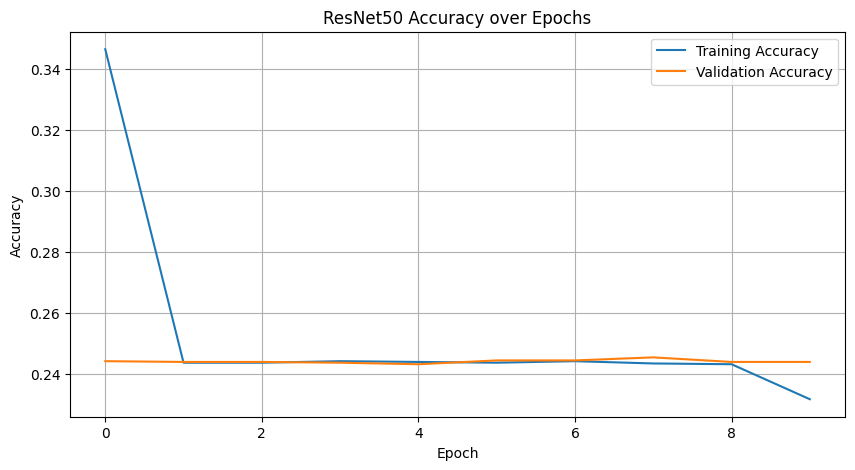

In [32]:
#Plot the training and validation accuracies over the epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()